### Pig grunts audio classification

In [1]:
import torch
import torchaudio
import IPython
import librosa
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from torch import nn
from torchsummary import summary
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from torch.utils.data import DataLoader, random_split, Dataset
from sklearn.model_selection import train_test_split, KFold
from pprint import pprint
from collections import defaultdict

#from torchvision import transforms


from model_v2 import *
from functions import *


print(torch.__version__)
print(torchaudio.__version__)

2.1.0
2.1.0


In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [41]:
# set all the parameters

data_path = os.path.join(os.getcwd(), 'Dataset')

fixed_sample_rate = 48000 #16000
num_samples = 98000 #16000
n_fft = 1024 #512 #1024
hop_length = 512
n_mels = 60 #64
n_mfcc = 60


transfo_mel = torchaudio.transforms.MelSpectrogram(
        sample_rate=fixed_sample_rate,
        n_fft=n_fft,
        normalized=True,
        hop_length=hop_length,
        n_mels=n_mels,
        center=True,
        pad_mode="reflect",
        power=2.0,
        norm="slaney",
        mel_scale="htk")

transfo_mfcc = torchaudio.transforms.MFCC(
        sample_rate=fixed_sample_rate,
        n_mfcc=n_mfcc,
        dct_type=2,
        norm='ortho',
        log_mels=False)

transfo_mfcc2 = torchaudio.transforms.MFCC(
        sample_rate=fixed_sample_rate,
        n_mfcc=n_mfcc,
        dct_type=2,
        norm='ortho',
        melkwargs={"n_fft": n_fft, 
                   "hop_length": hop_length, 
                   "n_mels": n_mels})

transfo_spectro = torchaudio.transforms.Spectrogram(
        n_fft=n_fft,
        hop_length = hop_length,
        power=2.0,
        normalized=False,
        center=True,
        pad_mode='reflect',
        onesided=True,
        return_complex=None)

C:\ProgramData\Anaconda3\lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [52]:

class CNN_mfcc2(nn.Module):

    def __init__(self):
        super().__init__()
        # 4 conv blocks / flatten / linear / softmax
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            ),
            nn.Dropout(p=0.5)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            ),
            nn.Dropout(p=0.5)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            ),
            nn.Dropout(p=0.5)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=2,
                padding=1
            ),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=4,
                stride=2
            ),
            nn.Dropout(p=0.5)
        )
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(640, 64)
#         self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,4)
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
#         print(x.shape)
        x = self.conv1(x)
#         print(x.shape)
        x = self.conv2(x)
#         print(x.shape)
        x = self.conv3(x)
#         print(x.shape)
        x = self.conv4(x)
#         print(x.shape)
        x = self.flatten(x)
#         print(x.shape)
        x = nn.ReLU()(self.fc1(x))
#         x = nn.ReLU()(self.fc2(x))
        x = self.fc3(x)
        
#         predictions = self.softmax(x)

        return x


In [53]:
# choose which transformation to apply to the waveforms + adjust necessary parameters/variables :

# transfo_applied = 'spectrogram'
# transfo_applied = 'mel_spectrogram'
transfo_applied = 'mfcc'


if transfo_applied == 'spectrogram':
    transformation = transfo_spectro
    cnn = CNN_spectro()
    best_model = CNN_spectro()
    random_tensor = torch.rand([64,1,513,192]).to(device)

elif transfo_applied == 'mel_spectrogram' :
    transformation = transfo_mel
    cnn = CNN_mel()
    best_model = CNN_mel()
    random_tensor = torch.rand([64,1,60,192]).to(device)

elif transfo_applied == 'mfcc':
    transformation = transfo_mfcc2
    cnn = CNN_mfcc2()
    best_model = CNN_mfcc2()
    random_tensor = torch.rand([64,1,60,491]).to(device)


In [54]:
# Create the custom dataset class + apply transformation to the data
    
class PigsAudioDataset(Dataset):
    def __init__(self, data_path, transformation, target_sample_rate, nr_samples):

        self.audio_dir = data_path
        self.transformation = transformation
        self.target_sample_rate = target_sample_rate
        self.nr_samples = nr_samples
        
    def __len__(self):
        folder_contents = os.listdir(self.audio_dir)
        return len(folder_contents)

    def __getitem__(self, idx):
        
        list_audio_paths, audio_path = self._get_audio_paths(self.audio_dir, idx)
        label = self._get_label(list_audio_paths, idx)
        
        # Load audio file
        waveform, sample_rate = torchaudio.load(audio_path)

        waveform = self._resample(waveform, sample_rate)
        waveform = self._mix_down(waveform)
        waveform = self._trim(waveform)
        waveform = self._zero_pad(waveform)
#         waveform = self._normalize(waveform)  # Apply normalization (if no Batch Normalization)
        transfo = self.transformation(waveform)
        
        return waveform, sample_rate, label, transfo


    def _get_audio_paths(self, directory_path, idx):
        # Get the list of all contents (files and directories) in the directory
        contents = os.listdir(directory_path)
        file_paths = []
        for item in contents:
            file_path = os.path.join(directory_path, item)  # Full path to the file
            file_paths.append(file_path)

        return file_paths, file_paths[idx]
    
    
    def _get_label(self, file_paths, idx):
        # Get the labels from the files' names
        labels = []
        for element in file_paths:
            name = element[:-4]
            label = int(name[-1])
            labels.append(label)
        
        return labels[idx]


    def _resample(self, wvf, sr):
        # If different sample rates
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.target_sample_rate)
            wvf = resampler(wvf)
        return wvf

    def _mix_down(self, wvf):
        # If more than one channel
        if wvf.shape[0] > 1:
            wvf = torch.mean(wvf, dim=0, keepdim=True)
        return wvf

    def _trim(self, wvf):
        # If signal too long
        if wvf.shape[1] > self.nr_samples :
            excess_samples = wvf.shape[1] - self.nr_samples
            left_trim = excess_samples // 2
            right_trim = excess_samples - left_trim
            wvf = wvf[:, left_trim:-right_trim]
        return wvf

    def _zero_pad(self, wvf):
        # If signal too short
        if wvf.shape[1] < self.nr_samples :
            nr_missing_samples = self.nr_samples - wvf.shape[1]
            wvf = torch.nn.functional.pad(wvf, (0, nr_missing_samples))
        return wvf
    
    def _normalize(self, wvf):
        # Min-max scaling to range [0, 1]
        min_val = torch.min(wvf)
        max_val = torch.max(wvf)
        normalized_wvf = (wvf - min_val) / (max_val - min_val)
        return normalized_wvf


In [55]:
# Create an instance of the dataset
dataset = PigsAudioDataset(data_path, transformation, fixed_sample_rate, num_samples)

In [56]:
k_folds = 2
generator = torch.manual_seed(453)

# create 2 distinct datasets : train with kfolds and hold-out test
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2], generator=generator)

# Define the K-Fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)


In [46]:
print( f'nr of observations in train set : {len(train_dataset)}')
print( f'nr of observations in test set : {len(test_dataset)}')
print(f'total length : {len(dataset)}')

nr of observations in train set : 1397
nr of observations in test set : 349
total length : 1746


FOLD 0
--------------------------------
length train_dataset fold n.0 : 1117


1117it [00:22, 50.75it/s]


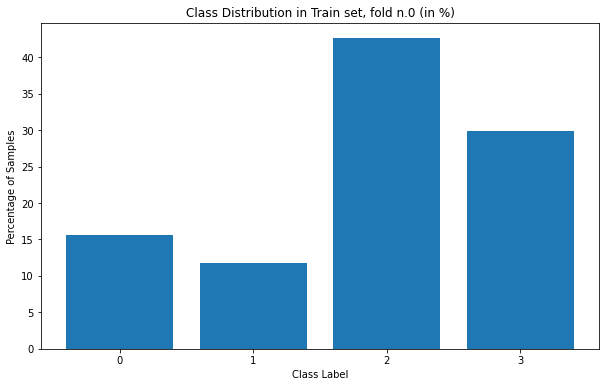

{0: 16, 1: 12, 2: 43, 3: 30}
length val_dataset fold n.0 : 280


280it [00:05, 52.95it/s]


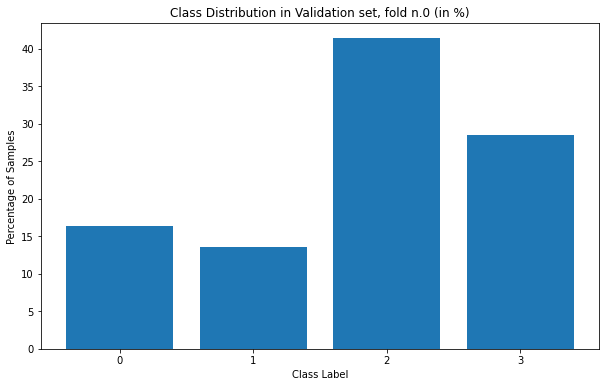

{0: 16, 1: 14, 2: 41, 3: 29}
FOLD 1
--------------------------------
length train_dataset fold n.1 : 1117


1117it [00:19, 58.38it/s]


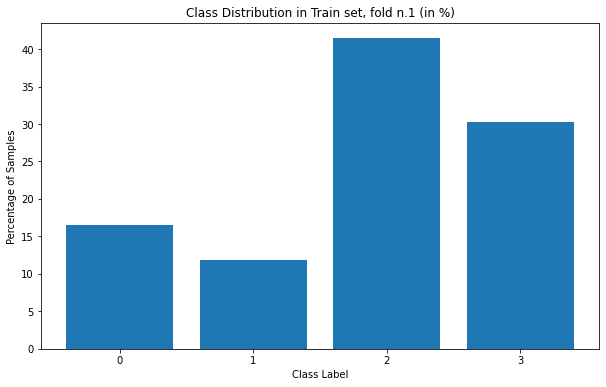

{0: 16, 1: 12, 2: 41, 3: 30}
length val_dataset fold n.1 : 280


280it [00:04, 57.05it/s]


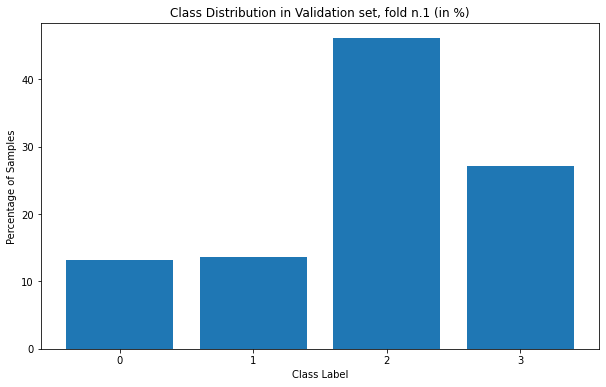

{0: 13, 1: 14, 2: 46, 3: 27}
FOLD 2
--------------------------------
length train_dataset fold n.2 : 1118


1118it [00:19, 56.70it/s]


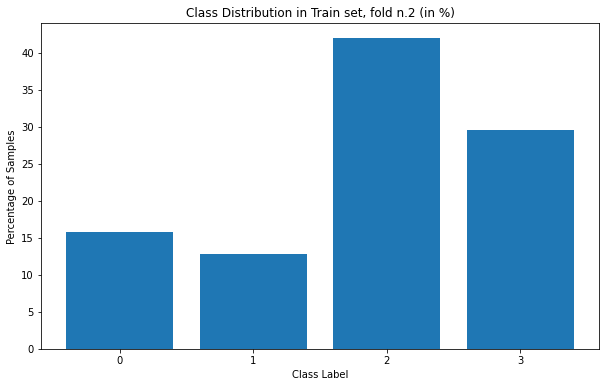

{0: 16, 1: 13, 2: 42, 3: 30}
length val_dataset fold n.2 : 279


279it [00:04, 56.56it/s]


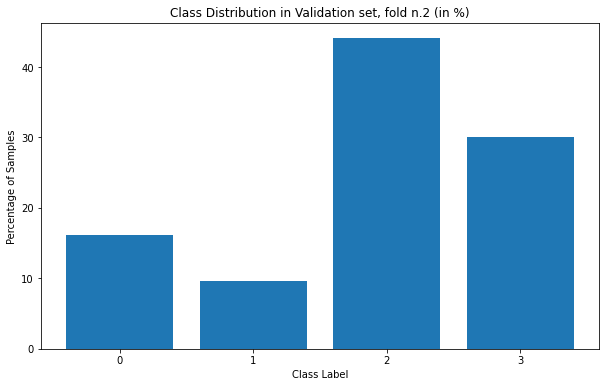

{0: 16, 1: 10, 2: 44, 3: 30}
FOLD 3
--------------------------------
length train_dataset fold n.3 : 1118


1118it [00:19, 56.27it/s]


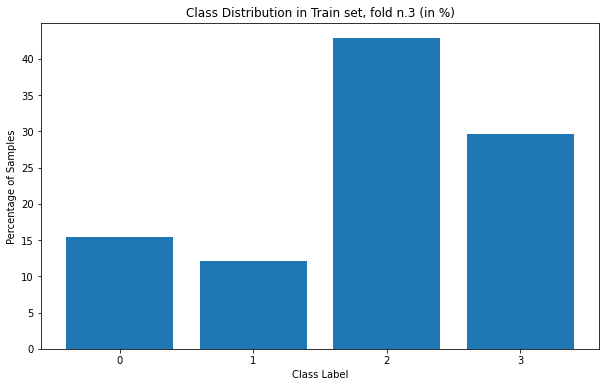

{0: 15, 1: 12, 2: 43, 3: 30}
length val_dataset fold n.3 : 279


279it [00:04, 56.39it/s]


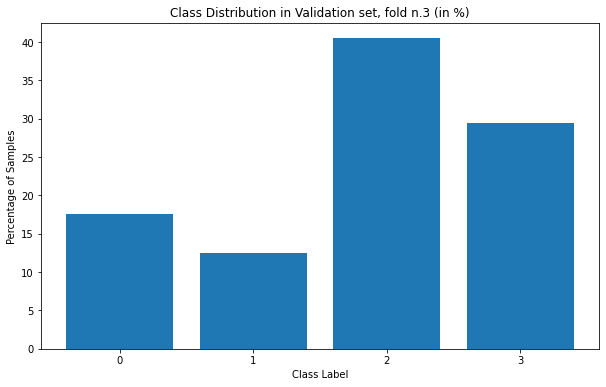

{0: 18, 1: 13, 2: 41, 3: 29}
FOLD 4
--------------------------------
length train_dataset fold n.4 : 1118


1118it [00:19, 57.90it/s]


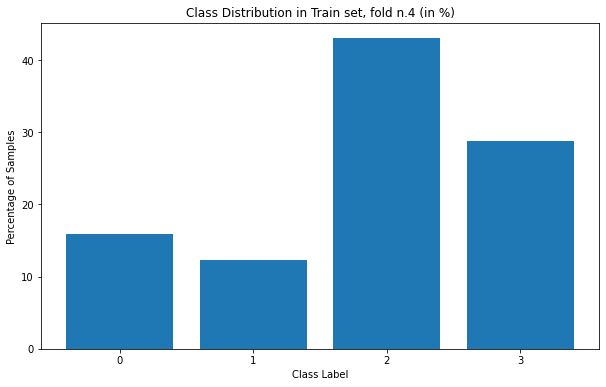

{0: 16, 1: 12, 2: 43, 3: 29}
length val_dataset fold n.4 : 279


279it [00:05, 54.99it/s]


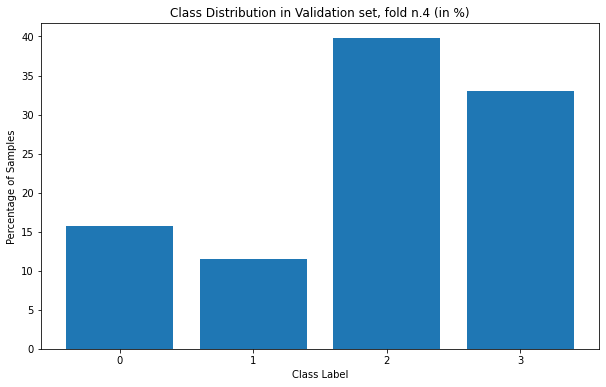

{0: 16, 1: 11, 2: 40, 3: 33}


In [10]:
batch_size = 32


for fold, (train_ids, val_ids) in enumerate(kfold.split(train_dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids
    train_subsampler = torch.utils.data.Subset(train_dataset, train_ids)
    val_subsampler = torch.utils.data.Subset(train_dataset, val_ids)
    
   
    # Define data loaders for training and validation data in this fold
    trainloader = torch.utils.data.DataLoader(
                      train_subsampler, 
                      batch_size=batch_size)
    valloader = torch.utils.data.DataLoader(
                      val_subsampler,
                      batch_size=batch_size)
    
    train_set = trainloader.dataset
    print(f"length train_dataset fold n.{fold} : {len(trainloader.dataset)}")
    class_distrib(train_set, f"Train set, fold n.{fold}")
    val_set = valloader.dataset
    print(f"length val_dataset fold n.{fold} : {len(valloader.dataset)}")
    class_distrib(val_set, f"Validation set, fold n.{fold}")

1746it [00:31, 55.52it/s]


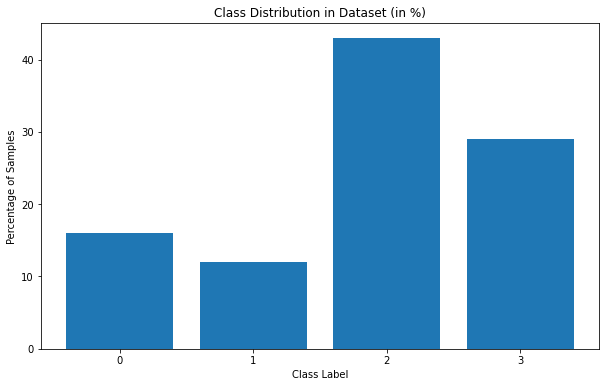

{0: 16, 1: 12, 2: 43, 3: 29}


In [11]:
# Class distribution of the entire dataset

class_distribution_percent, class_weights = class_distrib(dataset, 'Dataset')

In [12]:
# # Check if the dataset is balanced over all the classes in the different subsets

# class_distribution_percent_test, class_weights_test = class_distrib(test_dataset, 'Testing Dataset')
# class_distribution_percent_val, class_weights_val = class_distrib(val_dataset, 'Validation Dataset')
# class_distribution_percent_train, class_weights_train = class_distrib(train_dataset, 'Training Dataset')


In [13]:
# # Convert the class_weights dictionary to a tensor (for the loss)

# class_weights_train_tensor = class_weights_tensor(class_weights_train, device)
# class_weights_test_tensor = class_weights_tensor(class_weights_test, device)
# class_weights_val_tensor = class_weights_tensor(class_weights_val, device)

Dataset train - Number of Samples: 1397
Dataset test - Number of Samples: 349


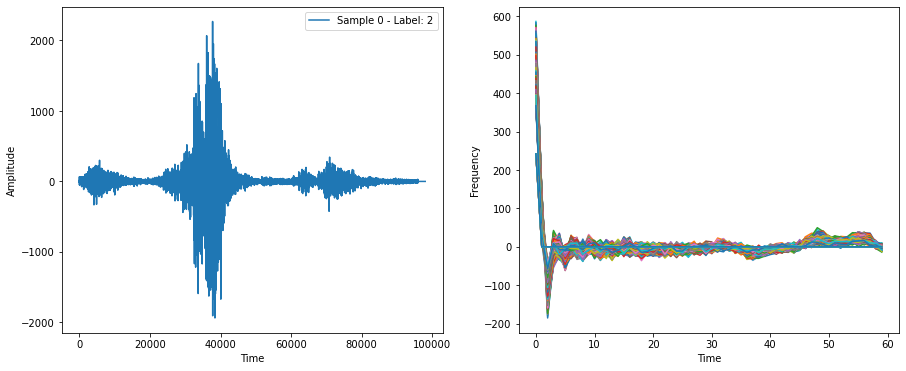

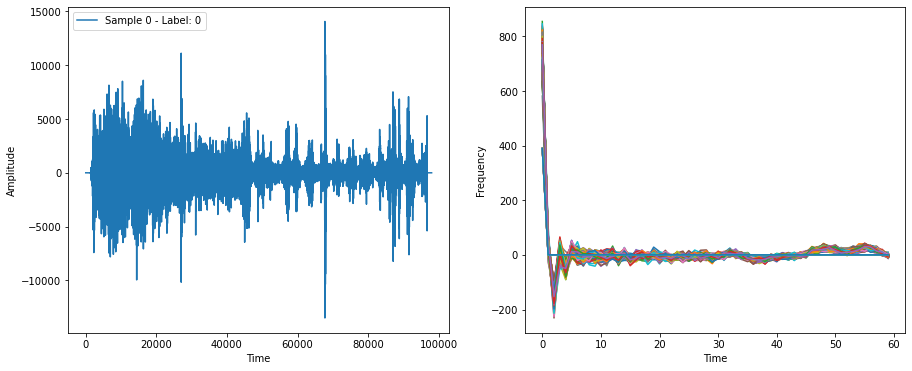

In [12]:
# see what's inside (plot waveforms and transformations (spectrograms, MFCCs or MelSpectrograms))
number_of_samples = 1
dataset_names = ["train", "test"]
datasets = [train_dataset, test_dataset]

for dataset, dataset_name in zip(datasets, dataset_names):

    plt.figure(figsize=(15,6))
    print(f"Dataset {dataset_name} - Number of Samples: {len(dataset)}")

    plt.clf()
    plt.title(f"Dataset {dataset_name}")

    ax = plt.subplot(121)
    for i in range(number_of_samples):
        waveform, sample_rate, label, _ = dataset[i]
        ax.plot(waveform.t(), label=f"Sample {i} - Label: {label}")
        ax.legend()

    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()

    ax = plt.subplot(122)
    for i in range(number_of_samples):
        waveform, sample_rate, label, transform = dataset[i]
        ax.plot(transform.squeeze(), label=f"Sample {i} - Label: {label}")
#        ax.legend()

    plt.xlabel("Time")
    plt.ylabel("Frequency")

plt.show()

In [13]:
# import librosa.display

# def plot_spectrogram2(specgram, sample_rate, title=None, ax=None):
#     if ax is None:
#         _, ax = plt.subplots(1, 1)
#     if title is not None:
#         ax.set_title(title)
#     librosa.display.specshow(librosa.power_to_db(specgram), sr=sample_rate, x_axis='time', y_axis='linear', ax=ax, cmap='viridis')
#     ax.set_ylabel('Frequency (Hz)')


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:7723: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


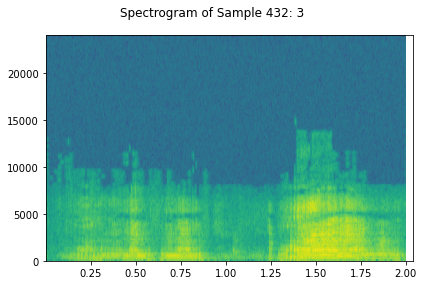

In [14]:
i = 432
waveform, sample_rate, label, _ = train_dataset[i]
plot_specgram(waveform, sample_rate, title=f"Spectrogram of Sample {i}: {label}")
IPython.display.Audio(waveform, rate=sample_rate)

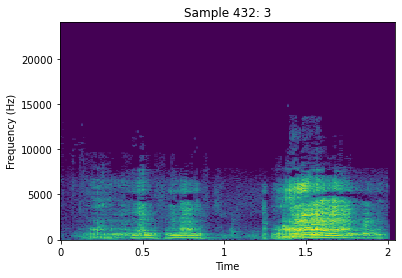

In [16]:
# Same as before
waveform, sample_rate, label, spectrogram = train_dataset[i]
plot_spectrogram2(torchaudio.transforms.Spectrogram(n_fft=n_fft)(waveform).squeeze(), sample_rate, title=f"Sample {i}: {label}") #'MFCC'
IPython.display.Audio(waveform, rate=sample_rate)


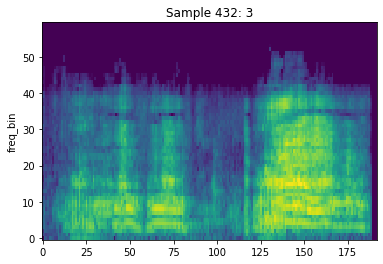

In [17]:
# melspectrogram
waveform, sample_rate, label, _ = train_dataset[i]
plot_spectrogram(transfo_mel(waveform).squeeze(), title=f"Sample {i}: {label}")
IPython.display.Audio(waveform, rate=sample_rate)

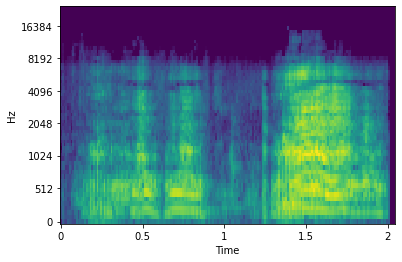

In [18]:
# mel spectro with librosa
melspec2 = librosa.feature.melspectrogram(y=waveform.numpy(), sr=48000, n_fft=1024, hop_length=512, n_mels=60)
melspec2 = librosa.power_to_db(melspec2, ref=np.max)

librosa.display.specshow(melspec2.squeeze(),sr=48000, y_axis='mel', x_axis='time', cmap='viridis')

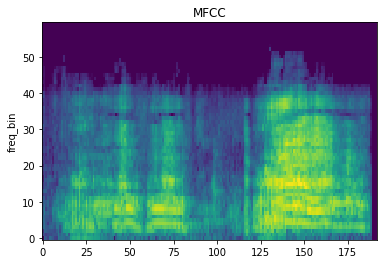

In [33]:
waveform, sample_rate, label, transform = train_dataset[i]
plot_spectrogram(transform[0], 'MFCC')
IPython.display.Audio(waveform, rate=sample_rate)


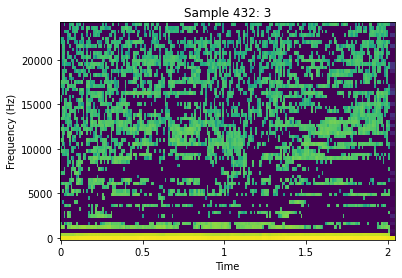

In [34]:
transfo_mfcc2 = torchaudio.transforms.MFCC(sample_rate=fixed_sample_rate,n_mfcc=n_mfcc,dct_type=2,norm='ortho',
                                           melkwargs={"n_fft": n_fft, "hop_length": hop_length, "n_mels": n_mels})
waveform, sample_rate, label, _ = train_dataset[i]
plot_spectrogram2(transfo_mfcc2(waveform).squeeze(), sample_rate, title=f"Sample {i}: {label}")
IPython.display.Audio(waveform, rate=sample_rate)


[Text(0.5, 1.0, 'MFCC')]

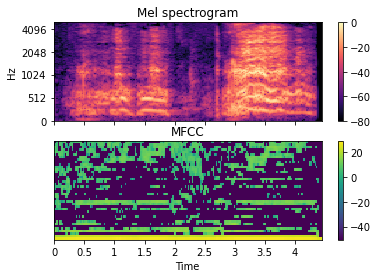

In [21]:
import librosa

#y, sample_rate = librosa.load(librosa.ex('libri1'))
y = waveform[0].numpy()

# compute the mel spectrogram and MFCCs
melspec = librosa.feature.melspectrogram( y=y, sr=sample_rate, n_mels=128, fmax=5000)
mfccs = librosa.feature.mfcc( y=y, sr=sample_rate, n_mfcc=40 )

# plot the mel spectrogram
fig, ax = plt.subplots(nrows=2, sharex=True)
img = librosa.display.specshow( librosa.power_to_db( melspec, ref=np.max), x_axis='time', y_axis='mel', fmax=5000, ax=ax[0] )
fig.colorbar(img, ax=[ax[0]])
ax[0].set(title='Mel spectrogram')
ax[0].label_outer()

# plot the MFCCs
img = librosa.display.specshow( librosa.power_to_db(mfccs), x_axis='time', ax=ax[1], cmap='viridis' )
fig.colorbar( img, ax=[ax[1]] )
ax[1].set(title='MFCC')

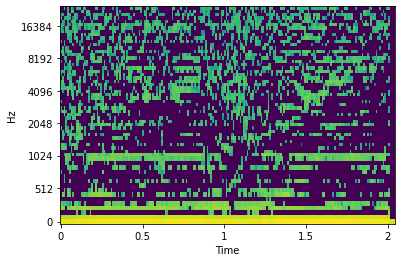

In [22]:
mfcc3 = librosa.feature.mfcc(y=waveform.numpy(), sr=48000, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

mfcc3 = librosa.power_to_db(mfcc3, ref=np.max)
librosa.display.specshow(mfcc3.squeeze(), sr=48000, y_axis='mel', x_axis='time', cmap='viridis')   

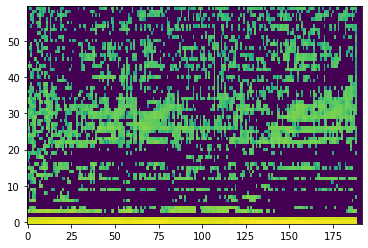

In [24]:
from python_speech_features import mfcc

mfcc_features = mfcc(
    signal=waveform,  # Input waveform
    samplerate=sample_rate,    # Sample rate of the waveform
    winlen=n_fft / sample_rate,  # Window length in seconds
    winstep=hop_length / sample_rate,  # Step between consecutive windows in seconds
    numcep=n_mfcc,             # Number of MFCC coefficients to return
    nfilt=n_mels,              # Number of Mel filters to be used
    nfft=n_fft,                # NFFT size
    preemph=0,                 # Pre-emphasis filter coefficient
    ceplifter=0,               # Apply cepstral lifter
    appendEnergy=False,       # If True, the zeroth cepstral coefficient is replaced with the log of the total frame energy
    winfunc=np.hamming
)
mfcc_data = np.swapaxes(mfcc_feat, 0 ,1)
plt.imshow((librosa.power_to_db(mfcc_data.squeeze())), interpolation='nearest', cmap='viridis', origin='lower', aspect='auto')
plt.show()

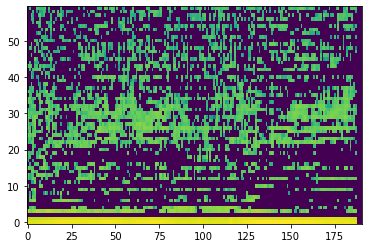

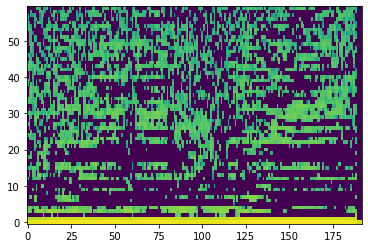

In [25]:
from scipy.signal.windows import hann
import seaborn as sns
mfcc_librosa = librosa.feature.mfcc(y=waveform.numpy(), sr=sample_rate, n_fft=n_fft,
                                    n_mfcc=n_mfcc, n_mels=n_mels,
                                    hop_length=hop_length, htk=True)
mfcc_speech = mfcc(signal=waveform.numpy(), samplerate=sample_rate, winlen=n_fft / sample_rate, winstep=hop_length / sample_rate,
                                          numcep=n_mfcc, nfilt=n_mels, nfft=n_fft,
                                          preemph=0.0, appendEnergy=False, winfunc=hann, ceplifter=0)
mfcc_speech = np.swapaxes(mfcc_speech, 0 ,1)

plt.imshow((librosa.power_to_db(mfcc_speech.squeeze())), interpolation='nearest', cmap='viridis', origin='lower', aspect='auto')
plt.show()

plt.imshow(librosa.power_to_db(mfcc_librosa.squeeze()), interpolation='nearest', cmap='viridis', origin='lower', aspect='auto')
plt.show()


In [64]:
n_epochs = 200
current_datetime = datetime.now()
date_string = current_datetime.strftime("%d.%m.%Y_%H-%M")
saving_path = f'outputs/{transfo_applied}_{n_epochs}_eps_{date_string}.pth'
results = {}
patience=8
# min_improvement=0.00

best_model_state_overall = None
best_val_loss_overall = float('inf')



print('--------------------------------')

for fold, (train_ids, val_ids) in enumerate(kfold.split(train_dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Create subsets of the train_dataset according to the given list of ids
    train_subset = torch.utils.data.Subset(train_dataset, train_ids)
    val_subset = torch.utils.data.Subset(train_dataset, val_ids)
    
    # Define data loaders for training and testing data in one fold
    trainloader = torch.utils.data.DataLoader(
                      train_subset, 
                      batch_size=batch_size)
    valloader = torch.utils.data.DataLoader(
                      val_subset,
                      batch_size=batch_size)
    
    # Initialize the neural network + losses
    if transfo_applied == 'mel_spectrogram' :
        model = CNN_mel()
    elif transfo_applied == 'mfcc':
        model = CNN_mfcc2()
    elif transfo_applied == 'spectrogram':
        model = CNN_spectro()

    train_criterion = nn.CrossEntropyLoss()
    val_criterion = nn.CrossEntropyLoss()

    model.to(device)
    model.apply(reset_weights)
    
    # Initialize optimizer
    optim = torch.optim.Adam(model.parameters(),lr=0.001)

   # Run the training loop for defined number of epochs      
    best_val_loss, best_model_state, train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(model, trainloader, valloader, optim, train_criterion, val_criterion, device, n_epochs, saving_path, fold, best_val_loss_overall, best_model_state_overall, results, patience=patience)

    if best_val_loss_overall == float('inf') :
        best_val_loss_overall = best_val_loss
        best_model_state_overall = best_model_state
    else :
        if best_val_loss < best_val_loss_overall :
            best_val_loss_overall = best_val_loss
            best_model_state_overall = best_model_state
            check = fold
                

# Save the best model state overall after all folds
if best_model_state_overall is not None:
    torch.save(best_model_state_overall, saving_path)


# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in results.items():
    print(f'Fold {key}: {value} %')
    sum += value
print(f'Average: {sum/len(results.items())} %')



--------------------------------
FOLD 0
--------------------------------
Starting epoch 0
Train Epoch: 0 [0/698 (0%)]	Loss: 1.560604
Train Epoch: 0 [320/698 (45%)]	Loss: 1.630660
Train Epoch: 0 [640/698 (91%)]	Loss: 1.358554
epoch n.0 : Average Loss = 1.4297393343665383, Accuracy = 36.10%
epoch n.0 : Val Average Loss = 1.3236231858080083, Val Accuracy = 41.92%
Starting epoch 1
Train Epoch: 1 [0/698 (0%)]	Loss: 1.362454
Train Epoch: 1 [320/698 (45%)]	Loss: 1.359862
Train Epoch: 1 [640/698 (91%)]	Loss: 1.325592
epoch n.1 : Average Loss = 1.2647246284918352, Accuracy = 45.27%
epoch n.1 : Val Average Loss = 1.275015191598372, Val Accuracy = 41.92%
Starting epoch 2
Train Epoch: 2 [0/698 (0%)]	Loss: 1.222644
Train Epoch: 2 [320/698 (45%)]	Loss: 1.070665
Train Epoch: 2 [640/698 (91%)]	Loss: 1.107925
epoch n.2 : Average Loss = 1.0831064961173318, Accuracy = 55.44%
epoch n.2 : Val Average Loss = 1.231497672471133, Val Accuracy = 41.92%
Starting epoch 3
Train Epoch: 3 [0/698 (0%)]	Loss: 0.792626

In [10]:
batch_size=32

In [65]:
# After training, to load the best model for inference or evaluation

state_dict = torch.load(saving_path, map_location=device)
best_model.load_state_dict(state_dict)
print(saving_path)
best_model.to(device)

outputs/mfcc_200_eps_19.02.2024_15-15.pth


CNN_mfcc2(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
  )


In [66]:
# load the hold-out test sample into a DataLoader + define the test loss criterion

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_criterion = nn.CrossEntropyLoss()

In [67]:
# test on an independant sample :
test_loss, test_accuracy = test_model(best_model, test_dataloader, test_criterion, device)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:06<00:00,  1.63it/s]


Test set: Average loss: 0.0137, Accuracy: 290/349 (83.1%)

Accuracy by class:
Class 0: 100.00%
Class 1: 35.00%
Class 2: 91.14%
Class 3: 79.35%


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:06<00:00,  1.68it/s]


Test set: Average loss: 0.0150, Accuracy: 284/349 (81.4%)

Accuracy by class:
Class 0: 100.00%
Class 1: 25.00%
Class 2: 89.24%
Class 3: 80.43%




Recall : [1.0, 0.25, 0.89, 0.8]
Specificity : [1.0, 0.96, 0.85, 0.91]
Precision : [1.0, 0.43, 0.83, 0.76]
Negative Precision : [1.0, 0.91, 0.91, 0.93]
False positive rate : [0.0, 0.04, 0.15, 0.09]
False negative rate : [0.0, 0.75, 0.11, 0.2]
False discovery rate : [0.0, 0.57, 0.17, 0.24]
Overall Accuracy : [1.0, 0.88, 0.87, 0.88]




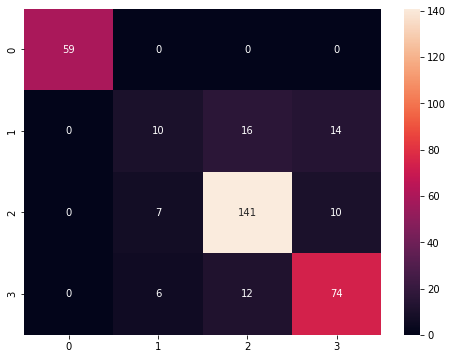

In [73]:
# from sklearn.metrics import confusion_matrix
# import pandas as pd

# def test_model2(model, testloader, criterion, device):
#     test_loss = 0
#     correct = 0
#     class_correct = defaultdict(int)
#     class_total = defaultdict(int)
#     predictions = []
#     targets = []
    
#     with torch.no_grad():
#         for wvf, _, target, transfo in tqdm(testloader):
#             wvf, target, transfo = wvf.to(device), target.to(device), transfo.to(device)
#             output = model(transfo)
#             test_loss += criterion(output, target).item()
#             pred = output.argmax(dim=1, keepdim=True)
#             correct += pred.eq(target.view_as(pred)).sum().item()
            
#             # Compute accuracies by class
#             for label, prediction in zip(target.cpu().numpy(), pred.cpu().numpy().flatten()):
#                 class_correct[label] += int(label == prediction)
#                 class_total[label] += 1

#             # Save predictions and true labels
#             predictions.extend(pred.cpu().numpy().flatten())
#             targets.extend(target.cpu().numpy())
            
#     test_loss /= len(testloader.dataset)
#     test_accuracy = 100 * correct / len(testloader.dataset)

#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
#         test_loss, correct, len(testloader.dataset), test_accuracy))
    
#     print("Accuracy by class:")
#     for i in range(len(class_correct)):
#         accuracy = 100 * class_correct[i] / class_total[i]
#         print(f"Class {i}: {accuracy:.2f}%")
#     print('\n')   
    
#     cm = confusion_matrix(targets, predictions)
#     df_cm2 = pd.DataFrame(cm, index=range(len(class_correct)), columns=range(len(class_correct)))
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(df_cm2, annot=True, fmt='d')
    
#     FP = cm.sum(axis=0) - np.diag(cm)
#     FN = cm.sum(axis=1) - np.diag(cm)
#     TP = np.diag(cm)
#     TN = cm.sum() - (FP + FN + TP)

#     print('\n')  
#     # Sensitivity, hit rate, recall, or true positive rate
#     TPR = TP / (TP + FN)
#     TPR = [round(elem, 2) for elem in TPR]
#     print('Recall :', TPR)
#     # Specificity or true negative rate
#     TNR = TN / (TN + FP)
#     TNR = [round(elem, 2) for elem in TNR]
#     print('Specificity :', TNR)
#     # Precision or positive predictive value
#     PPV = TP / (TP + FP)
#     PPV = [round(elem, 2) for elem in PPV]
#     print('Precision :', PPV)
#     # Negative predictive value
#     NPV = TN / (TN + FN)
#     NPV = [round(elem, 2) for elem in NPV]
#     print('Negative Precision :', NPV)
#     # Fall out or false positive rate
#     FPR = FP / (FP + TN)
#     FPR = [round(elem, 2) for elem in FPR]
#     print('False positive rate :', FPR)
#     # False negative rate
#     FNR = FN / (TP + FN)
#     FNR = [round(elem, 2) for elem in FNR]
#     print('False negative rate :', FNR)
#     # False discovery rate
#     FDR = FP / (TP + FP)
#     FDR = [round(elem, 2) for elem in FDR]
#     print('False discovery rate :', FDR)

#     # Overall accuracy
#     ACC = (TP + TN) / (TP + FP + FN + TN)
#     ACC = [round(elem, 2) for elem in ACC]
#     print('Overall Accuracy :', ACC)
#     print('\n')   

#     return test_loss, accuracy

# Test the model
test_loss, test_accuracy = test_model2(best_model, test_dataloader, test_criterion, device)

In [81]:
# Prediction/Inference on test data

i = random.randint(0,len(test_dataloader.dataset)-1)
input_data = test_dataloader.dataset[i][3].to(device)
target = test_dataloader.dataset[i][2] #.astype(np.int64)

predicted_label, expected_label = predict(best_model, input_data, target)
print(f"Predicted label : {predicted_label}, Expected label : {expected_label}")

Predicted label : 2, Expected label : 2


In [82]:
# Model summary
input_size = train_dataset[0][3].shape
summary(best_model, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 60, 192]             160
       BatchNorm2d-2          [-1, 16, 60, 192]              32
              ReLU-3          [-1, 16, 60, 192]               0
         MaxPool2d-4           [-1, 16, 30, 96]               0
           Dropout-5           [-1, 16, 30, 96]               0
            Conv2d-6           [-1, 32, 30, 96]           4,640
       BatchNorm2d-7           [-1, 32, 30, 96]              64
              ReLU-8           [-1, 32, 30, 96]               0
         MaxPool2d-9           [-1, 32, 15, 48]               0
          Dropout-10           [-1, 32, 15, 48]               0
           Conv2d-11           [-1, 64, 15, 48]          18,496
      BatchNorm2d-12           [-1, 64, 15, 48]             128
             ReLU-13           [-1, 64, 15, 48]               0
        MaxPool2d-14            [-1, 64

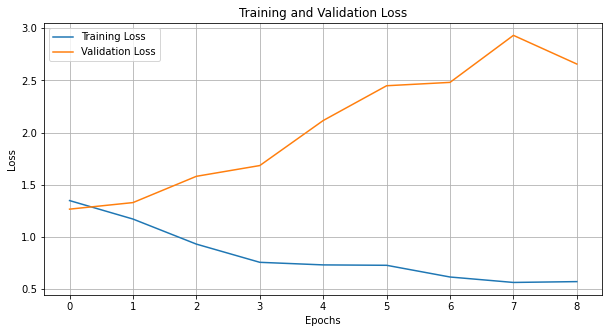

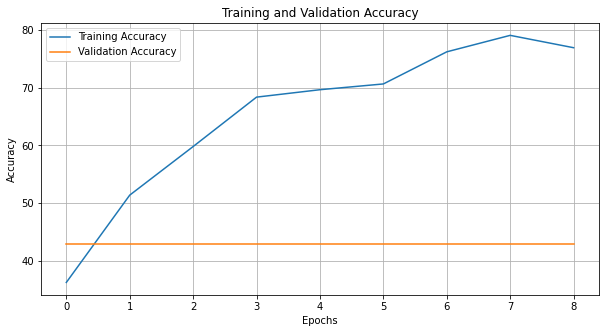

In [83]:
# plot learning curves (of the last fold)

# Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid()
plt.gca().set_facecolor('white')
file_name = f"outputs/losses_{transfo_applied}_{date_string}.png"
plt.savefig(file_name, bbox_inches='tight', pad_inches=0.15,facecolor='white', transparent=False)
plt.show()

# Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid()
plt.gca().set_facecolor('white')
file_name = f"outputs/accuracies_{transfo_applied}_{date_string}.png"
plt.savefig(file_name, facecolor='white', transparent=False, bbox_inches='tight', pad_inches=2)
plt.show()
